In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
from torchvision import transforms, models
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
from tqdm import tqdm
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torchvision.models import EfficientNet_V2_S_Weights
from torchvision.models import resnet18


In [2]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import os

class FERPlusImageFolderDataModule:
    def __init__(self, root_dir, batch_size=64):
        self.train_dir = os.path.join(root_dir, "train")
        self.test_dir = os.path.join(root_dir, "test")
        self.batch_size = batch_size
        

        
        self.train_transform = transforms.Compose([
            transforms.Resize((48, 48)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        
        self.eval_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
            transforms.Resize((48, 48)),                  # Standard FER size
            transforms.ToTensor(),                        # Convert to [0,1] tensor
            transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize grayscale
        ])

    def setup(self):
        self.train_dataset = ImageFolder(self.train_dir, transform=self.train_transform)
        self.test_dataset = ImageFolder(self.test_dir, transform=self.eval_transform)


        print("Train class distribution:")
        for cls in self.train_dataset.classes:
            count = len([x for x in self.train_dataset.samples if x[1] == self.train_dataset.class_to_idx[cls]])
        print(f"{cls}: {count}")

        
        # Split test into val + test manually (optional)
        val_size = int(0.5 * len(self.test_dataset))
        test_size = len(self.test_dataset) - val_size
        self.val_dataset, self.test_dataset = torch.utils.data.random_split(
            self.test_dataset, [val_size, test_size], generator=torch.Generator().manual_seed(42)
        )
    def train_dataloader(self):
        return DataLoader(self.train_dataset,batch_size=self.batch_size,shuffle=True,num_workers=4)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)


In [3]:
class EmotionDetectorResNet18(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionDetectorResNet18, self).__init__()
        self.model = resnet18(weights='IMAGENET1K_V1')  # Pretrained weights

        # Modify for grayscale input
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace final classifier
        self.model.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [4]:
class EmotionDetectorMobileNetV2(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionDetectorMobileNetV2, self).__init__()
        self.model = models.mobilenet_v2(pretrained=True)  # Using MobileNetV2 as base model

        self.model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        # Modify the classifier to match our problem
        self.model.classifier[1] = nn.Sequential(
            nn.Dropout(p=0.7),  # Increased dropout to 50%
            nn.Linear(self.model.classifier[1].in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [5]:
from torchvision.models import efficientnet_v2_s

class EmotionDetectorEffNet(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionDetectorEffNet, self).__init__()
        self.model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)  # Use pre-trained weights
        self.model.features[0][0] = nn.Conv2d(1, 24, kernel_size=3, stride=2, padding=1, bias=False)
        self.model.classifier[1] = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(self.model.classifier[1].in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import *
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm


def train_model(model, train_loader, val_loader, num_epochs, device, save_path="best_model.pth", lr=0.01, use_tqdm=True, train_dataset=None, early_stop_patience=10):
    model = model.to(device)
    labels = torch.tensor([s[1] for s in train_dataset.samples], dtype=torch.long)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0)
    warmup_epochs = 5  # You can adjust this
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5)
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': []
    }

    best_f1 = 0.0
    best_val_acc = 0.0
    best_val_loss = float('inf')  # Initialize best_val_loss with infinity
    best_model_path = save_path
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]") if use_tqdm else train_loader
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_bar.set_postfix(loss=running_loss / total, acc=100. * correct / total)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100. * correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]") if use_tqdm else val_loader
        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                val_bar.set_postfix(loss=val_loss / val_total, acc=100. * val_correct / val_total)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = 100. * val_correct / val_total

        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted', zero_division=0
        )

        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['val_precision'].append(precision)
        history['val_recall'].append(recall)
        history['val_f1'].append(f1)

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        print(f"Val Precision: {precision:.4f}, Val Recall: {recall:.4f}, Val F1: {f1:.4f}")

        

        # Save best model based on both accuracy and loss
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with Val F1: {best_f1:.4f} at {best_model_path}")
            no_improve_epochs = 0  # reset early stopping counter
        
        # else:
        #     no_improve_epochs += 1
        #     if no_improve_epochs >= early_stop_patience:
        #         print(f"Early stopping triggered after {early_stop_patience} epochs without improvement.")
        #         break

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scheduler.step(epoch_val_loss)

    final_model_path = save_path.replace(".pth", "_final.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved at {final_model_path}")

    return history



def test_model(model, test_loader, device, test_dataset=None):
    """
    Test function to evaluate the model on a test dataset.

    Args:
        model: Trained CNN model
        test_loader: DataLoader for test data
        device: Device to test on ('cuda' or 'cpu')
        test_dataset: Optional: dataset for calculating class weights (if needed)

    Returns:
        test_loss: Average test loss
        test_acc: Test accuracy
        precision: Weighted precision
        recall: Weighted recall
        f1: Weighted F1-score
    """
    print("Testing")
    model.load_state_dict(torch.load("/kaggle/working/best_emotion_model.pth"))

    model = model.to(device)
    model.eval()

    labels = torch.tensor([s[1] for s in test_dataset.dataset.samples], dtype=torch.long)
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    test_bar = tqdm(test_loader, desc="Testing")  # Add a progress bar for testing
    with torch.no_grad():
        for inputs, labels in test_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            test_bar.set_postfix(loss=test_loss / total, acc=100. * correct / total)

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = 100. * correct / total

    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )

    print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print(f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1: {f1:.4f}")

    return test_loss, test_acc, precision, recall, f1, all_preds, all_labels


In [7]:
# class WeightedCrossEntropyLoss(nn.Module):
#     def __init__(self, labels, device, num_classes=8):
#         super().__init__()
#         self.device = device
#         self.num_classes = num_classes
#         self.weights = self.__compute_weights(labels).to(device)
#         self.loss = nn.CrossEntropyLoss(weight=self.weights)

#     def __compute_weights(self, labels):
#         class_counts = torch.bincount(labels, minlength=self.num_classes)
#         total_samples = len(labels)
#         weights = total_samples / (self.num_classes * class_counts.float())
#         return weights

#     def forward(self, outputs, targets):
#         return self.loss(outputs, targets)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_loss_curve(train_loss, val_loss):
    """    
    Plots the training and validation loss curves.
    
    Parameters:       
    - train_loss: List of training loss values per epoch
    - val_loss: List of validation loss values per epoch
    """
    #Loss curve , still don't know list names 
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy_curve(train_acc, val_acc):
    """
    Plots training and validation accuracy per epoch.
    
    Args:
        train_acc (list): Training accuracy values
        val_acc (list): Validation accuracy values
    """
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label='Train Accuracy', marker='o')
    plt.plot(val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))



Train class distribution:
6: 6187


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 195MB/s]
Epoch 1/80 [Val]: 100%|██████████| 57/57 [00:14<00:00,  4.00it/s, acc=20, loss=2.58]  



Epoch 1/80
Train Loss: 1.9524, Train Acc: 17.17%
Val Loss: 2.5833, Val Acc: 19.98%
Val Precision: 0.1925, Val Recall: 0.1998, Val F1: 0.1943
Best model saved with Val F1: 0.1943 at /kaggle/working/best_emotion_model.pth


Epoch 2/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.44it/s, acc=25.2, loss=5.54]



Epoch 2/80
Train Loss: 1.9043, Train Acc: 21.20%
Val Loss: 5.5449, Val Acc: 25.25%
Val Precision: 0.2305, Val Recall: 0.2525, Val F1: 0.2276
Best model saved with Val F1: 0.2276 at /kaggle/working/best_emotion_model.pth


Epoch 3/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.47it/s, acc=30, loss=2.33]  



Epoch 3/80
Train Loss: 1.8613, Train Acc: 24.52%
Val Loss: 2.3345, Val Acc: 30.04%
Val Precision: 0.2640, Val Recall: 0.3004, Val F1: 0.2565
Best model saved with Val F1: 0.2565 at /kaggle/working/best_emotion_model.pth


Epoch 4/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.30it/s, acc=33.5, loss=1.79]



Epoch 4/80
Train Loss: 1.8063, Train Acc: 27.63%
Val Loss: 1.7898, Val Acc: 33.54%
Val Precision: 0.3016, Val Recall: 0.3354, Val F1: 0.2845
Best model saved with Val F1: 0.2845 at /kaggle/working/best_emotion_model.pth


Epoch 5/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.99it/s, acc=35.2, loss=1.64]



Epoch 5/80
Train Loss: 1.7535, Train Acc: 30.62%
Val Loss: 1.6448, Val Acc: 35.17%
Val Precision: 0.3220, Val Recall: 0.3517, Val F1: 0.2957
Best model saved with Val F1: 0.2957 at /kaggle/working/best_emotion_model.pth


Epoch 6/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.46it/s, acc=38.9, loss=1.58]



Epoch 6/80
Train Loss: 1.6979, Train Acc: 33.00%
Val Loss: 1.5791, Val Acc: 38.92%
Val Precision: 0.3537, Val Recall: 0.3892, Val F1: 0.3423
Best model saved with Val F1: 0.3423 at /kaggle/working/best_emotion_model.pth


Epoch 7/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.71it/s, acc=41.2, loss=1.58]



Epoch 7/80
Train Loss: 1.6502, Train Acc: 35.36%
Val Loss: 1.5833, Val Acc: 41.18%
Val Precision: 0.3876, Val Recall: 0.4118, Val F1: 0.3656
Best model saved with Val F1: 0.3656 at /kaggle/working/best_emotion_model.pth


Epoch 8/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.28it/s, acc=43, loss=1.49]  



Epoch 8/80
Train Loss: 1.6113, Train Acc: 37.04%
Val Loss: 1.4870, Val Acc: 43.00%
Val Precision: 0.3975, Val Recall: 0.4300, Val F1: 0.3914
Best model saved with Val F1: 0.3914 at /kaggle/working/best_emotion_model.pth


Epoch 9/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.62it/s, acc=45.6, loss=1.44]



Epoch 9/80
Train Loss: 1.5685, Train Acc: 39.34%
Val Loss: 1.4395, Val Acc: 45.64%
Val Precision: 0.4302, Val Recall: 0.4564, Val F1: 0.4201
Best model saved with Val F1: 0.4201 at /kaggle/working/best_emotion_model.pth


Epoch 10/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.91it/s, acc=47.2, loss=1.38]



Epoch 10/80
Train Loss: 1.5284, Train Acc: 41.14%
Val Loss: 1.3791, Val Acc: 47.19%
Val Precision: 0.4477, Val Recall: 0.4719, Val F1: 0.4383
Best model saved with Val F1: 0.4383 at /kaggle/working/best_emotion_model.pth


Epoch 11/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.69it/s, acc=49.4, loss=1.33]



Epoch 11/80
Train Loss: 1.4929, Train Acc: 42.76%
Val Loss: 1.3343, Val Acc: 49.42%
Val Precision: 0.4765, Val Recall: 0.4942, Val F1: 0.4677
Best model saved with Val F1: 0.4677 at /kaggle/working/best_emotion_model.pth


Epoch 12/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.52it/s, acc=50.6, loss=1.31]



Epoch 12/80
Train Loss: 1.4601, Train Acc: 44.07%
Val Loss: 1.3145, Val Acc: 50.61%
Val Precision: 0.4774, Val Recall: 0.5061, Val F1: 0.4747
Best model saved with Val F1: 0.4747 at /kaggle/working/best_emotion_model.pth


Epoch 13/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.98it/s, acc=52.6, loss=1.26]



Epoch 13/80
Train Loss: 1.4223, Train Acc: 45.98%
Val Loss: 1.2601, Val Acc: 52.65%
Val Precision: 0.5064, Val Recall: 0.5265, Val F1: 0.5045
Best model saved with Val F1: 0.5045 at /kaggle/working/best_emotion_model.pth


Epoch 14/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 19.07it/s, acc=54.2, loss=1.24]



Epoch 14/80
Train Loss: 1.3915, Train Acc: 47.35%
Val Loss: 1.2361, Val Acc: 54.16%
Val Precision: 0.5205, Val Recall: 0.5416, Val F1: 0.5190
Best model saved with Val F1: 0.5190 at /kaggle/working/best_emotion_model.pth


Epoch 15/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.50it/s, acc=54.9, loss=1.21]



Epoch 15/80
Train Loss: 1.3666, Train Acc: 48.50%
Val Loss: 1.2063, Val Acc: 54.85%
Val Precision: 0.5298, Val Recall: 0.5485, Val F1: 0.5282
Best model saved with Val F1: 0.5282 at /kaggle/working/best_emotion_model.pth


Epoch 16/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.54it/s, acc=56.4, loss=1.16]



Epoch 16/80
Train Loss: 1.3310, Train Acc: 49.82%
Val Loss: 1.1645, Val Acc: 56.45%
Val Precision: 0.5488, Val Recall: 0.5645, Val F1: 0.5466
Best model saved with Val F1: 0.5466 at /kaggle/working/best_emotion_model.pth


Epoch 17/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 19.19it/s, acc=57, loss=1.14]  



Epoch 17/80
Train Loss: 1.3016, Train Acc: 51.36%
Val Loss: 1.1384, Val Acc: 57.00%
Val Precision: 0.5545, Val Recall: 0.5700, Val F1: 0.5525
Best model saved with Val F1: 0.5525 at /kaggle/working/best_emotion_model.pth


Epoch 18/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.52it/s, acc=58.3, loss=1.11]



Epoch 18/80
Train Loss: 1.2749, Train Acc: 52.38%
Val Loss: 1.1120, Val Acc: 58.27%
Val Precision: 0.5662, Val Recall: 0.5827, Val F1: 0.5652
Best model saved with Val F1: 0.5652 at /kaggle/working/best_emotion_model.pth


Epoch 19/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 19.07it/s, acc=58.7, loss=1.09]



Epoch 19/80
Train Loss: 1.2455, Train Acc: 53.42%
Val Loss: 1.0943, Val Acc: 58.74%
Val Precision: 0.5711, Val Recall: 0.5874, Val F1: 0.5695
Best model saved with Val F1: 0.5695 at /kaggle/working/best_emotion_model.pth


Epoch 20/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 19.11it/s, acc=60.1, loss=1.07]



Epoch 20/80
Train Loss: 1.2157, Train Acc: 54.76%
Val Loss: 1.0651, Val Acc: 60.12%
Val Precision: 0.5883, Val Recall: 0.6012, Val F1: 0.5880
Best model saved with Val F1: 0.5880 at /kaggle/working/best_emotion_model.pth


Epoch 21/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.90it/s, acc=60.8, loss=1.04]



Epoch 21/80
Train Loss: 1.1871, Train Acc: 55.96%
Val Loss: 1.0437, Val Acc: 60.80%
Val Precision: 0.5965, Val Recall: 0.6080, Val F1: 0.5953
Best model saved with Val F1: 0.5953 at /kaggle/working/best_emotion_model.pth


Epoch 22/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.94it/s, acc=62.1, loss=1.01]



Epoch 22/80
Train Loss: 1.1615, Train Acc: 56.85%
Val Loss: 1.0126, Val Acc: 62.10%
Val Precision: 0.6113, Val Recall: 0.6210, Val F1: 0.6099
Best model saved with Val F1: 0.6099 at /kaggle/working/best_emotion_model.pth


Epoch 23/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.40it/s, acc=62.8, loss=0.997]



Epoch 23/80
Train Loss: 1.1307, Train Acc: 57.87%
Val Loss: 0.9968, Val Acc: 62.76%
Val Precision: 0.6155, Val Recall: 0.6276, Val F1: 0.6158
Best model saved with Val F1: 0.6158 at /kaggle/working/best_emotion_model.pth


Epoch 24/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.63it/s, acc=62.8, loss=0.98] 



Epoch 24/80
Train Loss: 1.1109, Train Acc: 58.90%
Val Loss: 0.9800, Val Acc: 62.76%
Val Precision: 0.6181, Val Recall: 0.6276, Val F1: 0.6155


Epoch 25/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.16it/s, acc=63.8, loss=0.951]



Epoch 25/80
Train Loss: 1.0807, Train Acc: 59.92%
Val Loss: 0.9514, Val Acc: 63.81%
Val Precision: 0.6298, Val Recall: 0.6381, Val F1: 0.6280
Best model saved with Val F1: 0.6280 at /kaggle/working/best_emotion_model.pth


Epoch 26/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.31it/s, acc=65, loss=0.936]  



Epoch 26/80
Train Loss: 1.0544, Train Acc: 60.98%
Val Loss: 0.9363, Val Acc: 65.05%
Val Precision: 0.6434, Val Recall: 0.6505, Val F1: 0.6396
Best model saved with Val F1: 0.6396 at /kaggle/working/best_emotion_model.pth


Epoch 27/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.39it/s, acc=66, loss=0.906]  



Epoch 27/80
Train Loss: 1.0297, Train Acc: 62.08%
Val Loss: 0.9063, Val Acc: 65.99%
Val Precision: 0.6535, Val Recall: 0.6599, Val F1: 0.6515
Best model saved with Val F1: 0.6515 at /kaggle/working/best_emotion_model.pth


Epoch 28/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.08it/s, acc=67, loss=0.893]  



Epoch 28/80
Train Loss: 1.0034, Train Acc: 62.86%
Val Loss: 0.8928, Val Acc: 66.95%
Val Precision: 0.6627, Val Recall: 0.6695, Val F1: 0.6615
Best model saved with Val F1: 0.6615 at /kaggle/working/best_emotion_model.pth


Epoch 29/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.05it/s, acc=67.6, loss=0.872]



Epoch 29/80
Train Loss: 0.9799, Train Acc: 63.79%
Val Loss: 0.8718, Val Acc: 67.61%
Val Precision: 0.6681, Val Recall: 0.6761, Val F1: 0.6671
Best model saved with Val F1: 0.6671 at /kaggle/working/best_emotion_model.pth


Epoch 30/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.99it/s, acc=69, loss=0.851]  



Epoch 30/80
Train Loss: 0.9555, Train Acc: 64.90%
Val Loss: 0.8510, Val Acc: 68.96%
Val Precision: 0.6854, Val Recall: 0.6896, Val F1: 0.6839
Best model saved with Val F1: 0.6839 at /kaggle/working/best_emotion_model.pth


Epoch 31/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.16it/s, acc=68.9, loss=0.839]



Epoch 31/80
Train Loss: 0.9316, Train Acc: 65.65%
Val Loss: 0.8392, Val Acc: 68.91%
Val Precision: 0.6850, Val Recall: 0.6891, Val F1: 0.6818


Epoch 32/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.13it/s, acc=69.8, loss=0.817]



Epoch 32/80
Train Loss: 0.9091, Train Acc: 66.72%
Val Loss: 0.8173, Val Acc: 69.79%
Val Precision: 0.6933, Val Recall: 0.6979, Val F1: 0.6923
Best model saved with Val F1: 0.6923 at /kaggle/working/best_emotion_model.pth


Epoch 33/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.76it/s, acc=70.3, loss=0.808]



Epoch 33/80
Train Loss: 0.8892, Train Acc: 66.92%
Val Loss: 0.8084, Val Acc: 70.34%
Val Precision: 0.6973, Val Recall: 0.7034, Val F1: 0.6952
Best model saved with Val F1: 0.6952 at /kaggle/working/best_emotion_model.pth


Epoch 34/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 15.20it/s, acc=70.8, loss=0.783]



Epoch 34/80
Train Loss: 0.8700, Train Acc: 67.77%
Val Loss: 0.7834, Val Acc: 70.76%
Val Precision: 0.7029, Val Recall: 0.7076, Val F1: 0.7022
Best model saved with Val F1: 0.7022 at /kaggle/working/best_emotion_model.pth


Epoch 35/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.18it/s, acc=71.1, loss=0.771]



Epoch 35/80
Train Loss: 0.8498, Train Acc: 68.57%
Val Loss: 0.7714, Val Acc: 71.09%
Val Precision: 0.7077, Val Recall: 0.7109, Val F1: 0.7073
Best model saved with Val F1: 0.7073 at /kaggle/working/best_emotion_model.pth


Epoch 36/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 16.14it/s, acc=71.3, loss=0.775]



Epoch 36/80
Train Loss: 0.8307, Train Acc: 69.37%
Val Loss: 0.7745, Val Acc: 71.31%
Val Precision: 0.7116, Val Recall: 0.7131, Val F1: 0.7084
Best model saved with Val F1: 0.7084 at /kaggle/working/best_emotion_model.pth


Epoch 37/80 [Val]: 100%|██████████| 57/57 [00:04<00:00, 12.86it/s, acc=71.9, loss=0.754]



Epoch 37/80
Train Loss: 0.8087, Train Acc: 69.82%
Val Loss: 0.7537, Val Acc: 71.86%
Val Precision: 0.7136, Val Recall: 0.7186, Val F1: 0.7126
Best model saved with Val F1: 0.7126 at /kaggle/working/best_emotion_model.pth


Epoch 38/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.46it/s, acc=72.6, loss=0.74] 



Epoch 38/80
Train Loss: 0.7873, Train Acc: 70.89%
Val Loss: 0.7401, Val Acc: 72.60%
Val Precision: 0.7233, Val Recall: 0.7260, Val F1: 0.7219
Best model saved with Val F1: 0.7219 at /kaggle/working/best_emotion_model.pth


Epoch 39/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.80it/s, acc=72.3, loss=0.732]



Epoch 39/80
Train Loss: 0.7736, Train Acc: 71.58%
Val Loss: 0.7321, Val Acc: 72.27%
Val Precision: 0.7223, Val Recall: 0.7227, Val F1: 0.7208


Epoch 40/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.14it/s, acc=72.9, loss=0.725]



Epoch 40/80
Train Loss: 0.7535, Train Acc: 72.11%
Val Loss: 0.7247, Val Acc: 72.93%
Val Precision: 0.7267, Val Recall: 0.7293, Val F1: 0.7256
Best model saved with Val F1: 0.7256 at /kaggle/working/best_emotion_model.pth


Epoch 41/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.99it/s, acc=72.7, loss=0.723]



Epoch 41/80
Train Loss: 0.7331, Train Acc: 72.79%
Val Loss: 0.7227, Val Acc: 72.68%
Val Precision: 0.7224, Val Recall: 0.7268, Val F1: 0.7218


Epoch 42/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.48it/s, acc=73.1, loss=0.715]



Epoch 42/80
Train Loss: 0.7193, Train Acc: 73.57%
Val Loss: 0.7147, Val Acc: 73.07%
Val Precision: 0.7271, Val Recall: 0.7307, Val F1: 0.7263
Best model saved with Val F1: 0.7263 at /kaggle/working/best_emotion_model.pth


Epoch 43/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.66it/s, acc=73.1, loss=0.706]



Epoch 43/80
Train Loss: 0.6994, Train Acc: 74.32%
Val Loss: 0.7061, Val Acc: 73.13%
Val Precision: 0.7276, Val Recall: 0.7313, Val F1: 0.7274
Best model saved with Val F1: 0.7274 at /kaggle/working/best_emotion_model.pth


Epoch 44/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.64it/s, acc=73.8, loss=0.708]



Epoch 44/80
Train Loss: 0.6821, Train Acc: 74.86%
Val Loss: 0.7078, Val Acc: 73.84%
Val Precision: 0.7377, Val Recall: 0.7384, Val F1: 0.7355
Best model saved with Val F1: 0.7355 at /kaggle/working/best_emotion_model.pth


Epoch 45/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.39it/s, acc=74.3, loss=0.702]



Epoch 45/80
Train Loss: 0.6610, Train Acc: 75.44%
Val Loss: 0.7016, Val Acc: 74.34%
Val Precision: 0.7428, Val Recall: 0.7434, Val F1: 0.7406
Best model saved with Val F1: 0.7406 at /kaggle/working/best_emotion_model.pth


Epoch 46/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.63it/s, acc=74.8, loss=0.699]



Epoch 46/80
Train Loss: 0.6473, Train Acc: 76.14%
Val Loss: 0.6991, Val Acc: 74.81%
Val Precision: 0.7452, Val Recall: 0.7481, Val F1: 0.7436
Best model saved with Val F1: 0.7436 at /kaggle/working/best_emotion_model.pth


Epoch 47/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.33it/s, acc=74.4, loss=0.697]



Epoch 47/80
Train Loss: 0.6391, Train Acc: 76.28%
Val Loss: 0.6967, Val Acc: 74.42%
Val Precision: 0.7398, Val Recall: 0.7442, Val F1: 0.7402


Epoch 48/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.81it/s, acc=75.3, loss=0.686]



Epoch 48/80
Train Loss: 0.6181, Train Acc: 77.00%
Val Loss: 0.6860, Val Acc: 75.33%
Val Precision: 0.7501, Val Recall: 0.7533, Val F1: 0.7501
Best model saved with Val F1: 0.7501 at /kaggle/working/best_emotion_model.pth


Epoch 49/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.07it/s, acc=75.3, loss=0.688]



Epoch 49/80
Train Loss: 0.5999, Train Acc: 77.90%
Val Loss: 0.6883, Val Acc: 75.30%
Val Precision: 0.7500, Val Recall: 0.7530, Val F1: 0.7501
Best model saved with Val F1: 0.7501 at /kaggle/working/best_emotion_model.pth


Epoch 50/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.63it/s, acc=76, loss=0.681]  



Epoch 50/80
Train Loss: 0.5911, Train Acc: 78.36%
Val Loss: 0.6808, Val Acc: 75.96%
Val Precision: 0.7572, Val Recall: 0.7596, Val F1: 0.7562
Best model saved with Val F1: 0.7562 at /kaggle/working/best_emotion_model.pth


Epoch 51/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 19.25it/s, acc=75.5, loss=0.678]



Epoch 51/80
Train Loss: 0.5720, Train Acc: 78.99%
Val Loss: 0.6778, Val Acc: 75.52%
Val Precision: 0.7525, Val Recall: 0.7552, Val F1: 0.7520


Epoch 52/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 19.30it/s, acc=76, loss=0.68]   



Epoch 52/80
Train Loss: 0.5602, Train Acc: 79.22%
Val Loss: 0.6801, Val Acc: 75.96%
Val Precision: 0.7571, Val Recall: 0.7596, Val F1: 0.7568
Best model saved with Val F1: 0.7568 at /kaggle/working/best_emotion_model.pth


Epoch 53/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.17it/s, acc=75.9, loss=0.683]



Epoch 53/80
Train Loss: 0.5399, Train Acc: 80.21%
Val Loss: 0.6835, Val Acc: 75.91%
Val Precision: 0.7559, Val Recall: 0.7591, Val F1: 0.7552


Epoch 54/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.20it/s, acc=76.4, loss=0.682]



Epoch 54/80
Train Loss: 0.5289, Train Acc: 80.56%
Val Loss: 0.6818, Val Acc: 76.35%
Val Precision: 0.7618, Val Recall: 0.7635, Val F1: 0.7602
Best model saved with Val F1: 0.7602 at /kaggle/working/best_emotion_model.pth


Epoch 55/80 [Val]: 100%|██████████| 57/57 [00:04<00:00, 12.90it/s, acc=76.1, loss=0.681]



Epoch 55/80
Train Loss: 0.5171, Train Acc: 81.28%
Val Loss: 0.6808, Val Acc: 76.10%
Val Precision: 0.7582, Val Recall: 0.7610, Val F1: 0.7573


Epoch 56/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 15.37it/s, acc=76, loss=0.681]  



Epoch 56/80
Train Loss: 0.4967, Train Acc: 81.67%
Val Loss: 0.6805, Val Acc: 76.02%
Val Precision: 0.7572, Val Recall: 0.7602, Val F1: 0.7578


Epoch 57/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.55it/s, acc=76.5, loss=0.685]



Epoch 57/80
Train Loss: 0.4781, Train Acc: 82.53%
Val Loss: 0.6854, Val Acc: 76.46%
Val Precision: 0.7642, Val Recall: 0.7646, Val F1: 0.7626
Best model saved with Val F1: 0.7626 at /kaggle/working/best_emotion_model.pth


Epoch 58/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.42it/s, acc=76.8, loss=0.685]



Epoch 58/80
Train Loss: 0.4772, Train Acc: 82.70%
Val Loss: 0.6845, Val Acc: 76.79%
Val Precision: 0.7658, Val Recall: 0.7679, Val F1: 0.7647
Best model saved with Val F1: 0.7647 at /kaggle/working/best_emotion_model.pth


Epoch 59/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.68it/s, acc=76.7, loss=0.69] 



Epoch 59/80
Train Loss: 0.4611, Train Acc: 83.21%
Val Loss: 0.6900, Val Acc: 76.65%
Val Precision: 0.7649, Val Recall: 0.7665, Val F1: 0.7641


Epoch 60/80 [Val]: 100%|██████████| 57/57 [00:04<00:00, 14.06it/s, acc=77, loss=0.694]  



Epoch 60/80
Train Loss: 0.4414, Train Acc: 84.00%
Val Loss: 0.6942, Val Acc: 76.96%
Val Precision: 0.7693, Val Recall: 0.7696, Val F1: 0.7672
Best model saved with Val F1: 0.7672 at /kaggle/working/best_emotion_model.pth


Epoch 61/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 15.43it/s, acc=77, loss=0.704]  



Epoch 61/80
Train Loss: 0.4360, Train Acc: 83.95%
Val Loss: 0.7045, Val Acc: 77.04%
Val Precision: 0.7691, Val Recall: 0.7704, Val F1: 0.7675
Best model saved with Val F1: 0.7675 at /kaggle/working/best_emotion_model.pth


Epoch 62/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.34it/s, acc=76.8, loss=0.707]



Epoch 62/80
Train Loss: 0.4212, Train Acc: 84.52%
Val Loss: 0.7070, Val Acc: 76.85%
Val Precision: 0.7668, Val Recall: 0.7685, Val F1: 0.7655


Epoch 63/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.10it/s, acc=76.7, loss=0.715]



Epoch 63/80
Train Loss: 0.4192, Train Acc: 84.65%
Val Loss: 0.7150, Val Acc: 76.68%
Val Precision: 0.7651, Val Recall: 0.7668, Val F1: 0.7629


Epoch 64/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 14.84it/s, acc=77.5, loss=0.712]



Epoch 64/80
Train Loss: 0.4120, Train Acc: 85.09%
Val Loss: 0.7121, Val Acc: 77.51%
Val Precision: 0.7738, Val Recall: 0.7751, Val F1: 0.7726
Best model saved with Val F1: 0.7726 at /kaggle/working/best_emotion_model.pth


Epoch 65/80 [Val]: 100%|██████████| 57/57 [00:04<00:00, 13.60it/s, acc=77.1, loss=0.724]



Epoch 65/80
Train Loss: 0.4016, Train Acc: 85.44%
Val Loss: 0.7237, Val Acc: 77.12%
Val Precision: 0.7694, Val Recall: 0.7712, Val F1: 0.7677


Epoch 66/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 15.03it/s, acc=77.5, loss=0.711]



Epoch 66/80
Train Loss: 0.4028, Train Acc: 85.37%
Val Loss: 0.7114, Val Acc: 77.45%
Val Precision: 0.7729, Val Recall: 0.7745, Val F1: 0.7720


Epoch 67/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.92it/s, acc=77.5, loss=0.715]



Epoch 67/80
Train Loss: 0.3912, Train Acc: 85.82%
Val Loss: 0.7149, Val Acc: 77.48%
Val Precision: 0.7728, Val Recall: 0.7748, Val F1: 0.7725


Epoch 68/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.29it/s, acc=77.4, loss=0.717]



Epoch 68/80
Train Loss: 0.3851, Train Acc: 86.07%
Val Loss: 0.7174, Val Acc: 77.43%
Val Precision: 0.7724, Val Recall: 0.7743, Val F1: 0.7723


Epoch 69/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.29it/s, acc=77.1, loss=0.726]



Epoch 69/80
Train Loss: 0.3748, Train Acc: 86.45%
Val Loss: 0.7259, Val Acc: 77.15%
Val Precision: 0.7704, Val Recall: 0.7715, Val F1: 0.7683


Epoch 70/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 18.23it/s, acc=77.5, loss=0.731]



Epoch 70/80
Train Loss: 0.3775, Train Acc: 86.24%
Val Loss: 0.7311, Val Acc: 77.48%
Val Precision: 0.7740, Val Recall: 0.7748, Val F1: 0.7727
Best model saved with Val F1: 0.7727 at /kaggle/working/best_emotion_model.pth


Epoch 71/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 16.72it/s, acc=77.7, loss=0.727]



Epoch 71/80
Train Loss: 0.3716, Train Acc: 86.63%
Val Loss: 0.7272, Val Acc: 77.67%
Val Precision: 0.7757, Val Recall: 0.7767, Val F1: 0.7748
Best model saved with Val F1: 0.7748 at /kaggle/working/best_emotion_model.pth


Epoch 72/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 14.76it/s, acc=77.4, loss=0.725]



Epoch 72/80
Train Loss: 0.3790, Train Acc: 86.21%
Val Loss: 0.7250, Val Acc: 77.40%
Val Precision: 0.7732, Val Recall: 0.7740, Val F1: 0.7721


Epoch 73/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.26it/s, acc=77.6, loss=0.732]



Epoch 73/80
Train Loss: 0.3652, Train Acc: 86.66%
Val Loss: 0.7321, Val Acc: 77.59%
Val Precision: 0.7749, Val Recall: 0.7759, Val F1: 0.7742


Epoch 74/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 16.52it/s, acc=77.6, loss=0.735]



Epoch 74/80
Train Loss: 0.3616, Train Acc: 86.82%
Val Loss: 0.7354, Val Acc: 77.65%
Val Precision: 0.7771, Val Recall: 0.7765, Val F1: 0.7741


Epoch 75/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.30it/s, acc=77.7, loss=0.736]



Epoch 75/80
Train Loss: 0.3636, Train Acc: 86.90%
Val Loss: 0.7358, Val Acc: 77.70%
Val Precision: 0.7758, Val Recall: 0.7770, Val F1: 0.7744


Epoch 76/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.66it/s, acc=77.6, loss=0.74] 



Epoch 76/80
Train Loss: 0.3509, Train Acc: 87.21%
Val Loss: 0.7401, Val Acc: 77.62%
Val Precision: 0.7747, Val Recall: 0.7762, Val F1: 0.7730


Epoch 77/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 15.59it/s, acc=78, loss=0.736]  



Epoch 77/80
Train Loss: 0.3514, Train Acc: 87.15%
Val Loss: 0.7360, Val Acc: 77.98%
Val Precision: 0.7797, Val Recall: 0.7798, Val F1: 0.7781
Best model saved with Val F1: 0.7781 at /kaggle/working/best_emotion_model.pth


Epoch 78/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.27it/s, acc=78, loss=0.742]  



Epoch 78/80
Train Loss: 0.3474, Train Acc: 87.39%
Val Loss: 0.7424, Val Acc: 78.00%
Val Precision: 0.7787, Val Recall: 0.7800, Val F1: 0.7774


Epoch 79/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 17.91it/s, acc=77.8, loss=0.739]



Epoch 79/80
Train Loss: 0.3464, Train Acc: 87.55%
Val Loss: 0.7390, Val Acc: 77.81%
Val Precision: 0.7769, Val Recall: 0.7781, Val F1: 0.7754


Epoch 80/80 [Val]: 100%|██████████| 57/57 [00:03<00:00, 16.08it/s, acc=77.7, loss=0.739]



Epoch 80/80
Train Loss: 0.3534, Train Acc: 87.14%
Val Loss: 0.7391, Val Acc: 77.67%
Val Precision: 0.7756, Val Recall: 0.7767, Val F1: 0.7739
Final model saved at /kaggle/working/best_emotion_model_final.pth
Testing


Testing: 100%|██████████| 57/57 [00:18<00:00,  3.13it/s, acc=77.9, loss=0.706]



Test Loss: 0.7060, Test Acc: 77.92%
Test Precision: 0.7805, Test Recall: 0.7792, Test F1: 0.7781


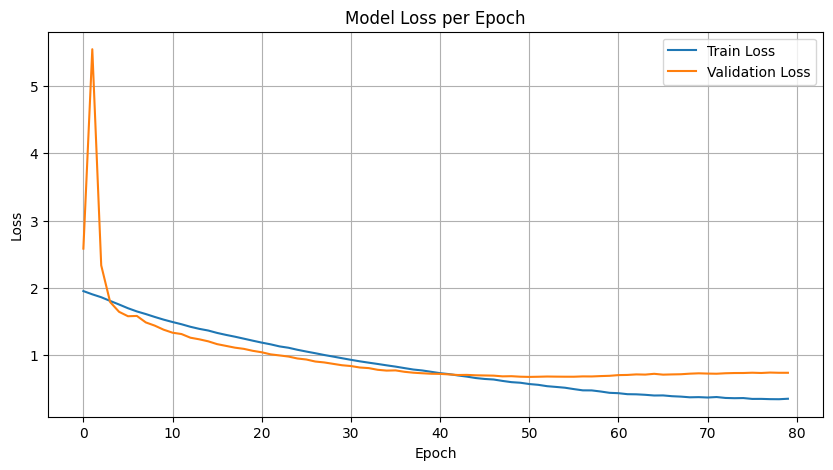

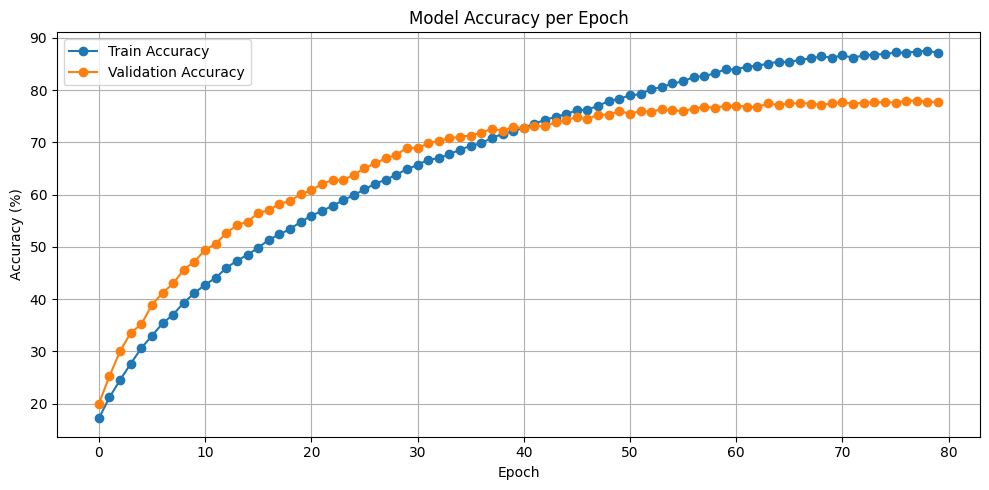

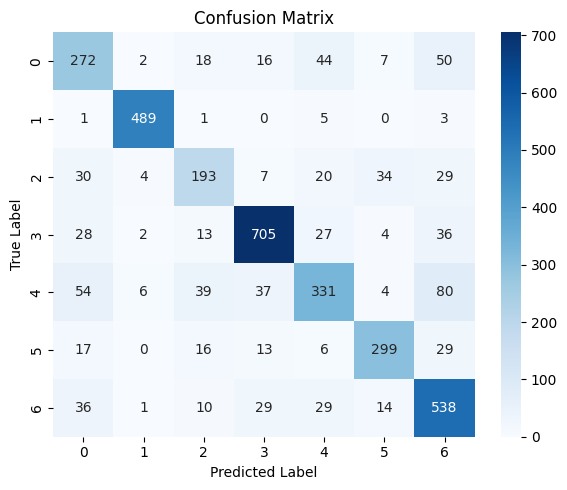


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.67      0.64       409
           1       0.97      0.98      0.98       499
           2       0.67      0.61      0.64       317
           3       0.87      0.87      0.87       815
           4       0.72      0.60      0.65       551
           5       0.83      0.79      0.81       380
           6       0.70      0.82      0.76       657

    accuracy                           0.78      3628
   macro avg       0.77      0.76      0.76      3628
weighted avg       0.78      0.78      0.78      3628



In [9]:
# Config
root_dir = "/kaggle/input/ferplus/FER+"
batch_size = 64
num_classes = 7
num_epochs = 80
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path = "/kaggle/working/best_emotion_model.pth"

# Data setup
data_module = FERPlusImageFolderDataModule(root_dir, batch_size)
data_module.setup()

train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()



model = EmotionDetectorEffNet(num_classes=num_classes)


original_train_dataset = data_module.train_dataset

history = train_model(model, train_loader, val_loader, num_epochs, device, save_path,
                      lr=1e-5, train_dataset=original_train_dataset)



original_test_dataset = data_module.test_dataset
test_loss, test_acc, precision, recall, f1, all_preds, all_labels = test_model(
    model, test_loader, device, test_dataset=original_test_dataset
)


plot_loss_curve(history['train_loss'], history['val_loss'])
plot_accuracy_curve(history['train_acc'], history['val_acc'])

class_names = data_module.train_dataset.classes
plot_confusion_matrix(all_labels, all_preds, class_names)
torch.save(model, "/kaggle/working/emotion_model_full.pt")
